In [1]:
# test if adding synthetic data to imbalance dataset, the classification accuracy can increase
# test dataset: UNIMIB, MITBIH 

In [2]:
from MITBIH import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
mixed_ecg = mixed_mitbih(real_samples = 200, syn_samples = 800)

data shape is (4000, 1, 128)
labels shape is (4000,)
The dataset including 800 class 0, 800 class 1, 800 class 2, 800 class 3, 800 class 4
X_train shape is (87554, 1, 128)
y_train shape is (87554,)
The dataset including 72471 class 0, 2223 class 1, 5788 class 2, 641 class 3, 6431 class 4
data shape is (5000, 1, 128)
labels shape is (5000,)


In [4]:
real_test_ecg_imbalanced = mitbih_allClass(filename='./datasets/MITBIH/mitbih_test.csv', isBalanced = False, oneD=True)

X_train shape is (21892, 1, 128)
y_train shape is (21892,)
The dataset including 18118 class 0, 556 class 1, 1448 class 2, 162 class 3, 1608 class 4


In [5]:
real_test_ecg_balanced = mitbih_allClass(filename='./datasets/MITBIH/mitbih_test.csv', isBalanced = True, n_samples = 500, oneD=True)

X_train shape is (2500, 1, 128)
y_train shape is (2500,)
The dataset including 500 class 0, 500 class 1,                   500 class 2, 500 class 3, 500 class 4


In [6]:
syn_ecg = syn_mitbih()

data shape is (5000, 1, 128)
labels shape is (5000,)
The dataset including 1000 class 0, 1000 class 1, 1000 class 2, 1000 class 3, 1000 class 4


In [7]:
real_ecg = mitbih_allClass(filename='./datasets/MITBIH/mitbih_train.csv', isBalanced = True, n_samples = 1000, oneD=True)

X_train shape is (5000, 1, 128)
y_train shape is (5000,)
The dataset including 1000 class 0, 1000 class 1,                   1000 class 2, 1000 class 3, 1000 class 4


In [8]:
from torch.utils import data
syn_loader = data.DataLoader(syn_ecg, batch_size=32, num_workers=4, shuffle=True)
real_loader = data.DataLoader(real_ecg, batch_size=32, num_workers=4, shuffle=True)
mixed_loader = data.DataLoader(mixed_ecg, batch_size=32, num_workers=4, shuffle=True)
# test_real_loader = data.DataLoader(real_test_ecg, batch_size=32, num_workers=4, shuffle=True)

#real_ecg_imbalanced_loader = data.DataLoader(real_ecg_imbalanced, batch_size=32, num_workers=4, shuffle=True)
real_test_ecg_imbalanced_loader = data.DataLoader(real_test_ecg_imbalanced, batch_size=32, num_workers=4, shuffle=True)
# real_ecg_balanced_loader = data.DataLoader(real_ecg_balanced, batch_size=32, num_workers=4, shuffle=True)
# mixed_balanced_loader = data.DataLoader(mixed_ecg_balanced, batch_size=32, num_workers=4, shuffle=True)

In [9]:
real_test_ecg_balanced_loader = data.DataLoader(real_test_ecg_balanced, batch_size=32, num_workers=4, shuffle=True)

In [10]:
#Define a simple CNN classifier 
import torch
import torch.nn as nn
import torch.nn.functional as F


class ECG_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 6, padding = 3)
        self.conv2 = nn.Conv1d(64, 64, 6, padding = 3)
        self.conv3 = nn.Conv1d(64, 64, 3, padding = 1)
        self.dropout = nn.Dropout(p=0.5) 
        self.pool = nn.MaxPool1d(3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(896, 100)
        self.fc2 = nn.Linear(100, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [11]:
def train(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, filename="test_cm", save_name='model'):
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(train_data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()

#             y_pred = torch.round(torch.sigmoid(outputs))
# #             y_pred = torch.round(outputs)
#             correct = (y_pred == labels).sum()
#             total_correct += correct
#             total += len(labels)
            
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

        epoch_train_loss = total_loss / len(train_data_loader)
        epoch_train_acc = correct / total
        print(f'Epoch {epoch + 1}, train loss = {epoch_train_loss}, train acc = {epoch_train_acc}')

        if (epoch+1) % 5 == 0:
            _eval(model, test_data_loader, criterion, epoch)
#             _eval_single_class(model, test_data_loader, criterion, epoch)
            
    _final_eval(model, test_data_loader, criterion, filename)
    torch.save(model, f'./saved_model/{save_name}.pt')

    print('Finished Training and testing')

In [12]:
def _eval(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()

#             y_pred = torch.round(torch.sigmoid(outputs))
#             correct = (y_pred == labels).sum()
#             total_correct += correct
#             total += len(labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_test_loss = total_loss / len(real_test_loader)
        epoch_test_acc = correct / total
    
    print('=====================================================')
    print(f'Epoch {epoch+1}, test loss = {epoch_test_loss}, test acc = {epoch_test_acc}')
    print('=====================================================')

In [13]:
classes = ['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats', 'Unknown', 'Fusion Beats']
classes_idx = ['1','2','3','4','5']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [14]:
def _eval_single_class(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def _final_eval(model, real_test_loader, criterion, filename="test_cm"):
    nb_classes = 5
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    target_names = classes
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,predictions.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
            y_preds.append(predictions)
            y_trues.append(labels)
            
    # Confusion matrix
    cm=confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(cm)
    cm_df = pd.DataFrame(cm,
                     index = classes_idx, 
                     columns = classes_idx)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#     plt.title('ECG classification Accuracy')
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.savefig(f'{filename}.pdf')
    plt.show()
    
    # Per-class accuracy
    class_accuracy = 100*cm.diagonal() / cm.sum(1)
    print(class_accuracy)
    
    #print classification report 
#     y_preds = np.array(y_preds)
#     y_trues = np.array(y_trues)
    y_preds_flatten = [label for sublist in y_preds for label in sublist]
    y_trues_flatten = [label for sublist in y_trues for label in sublist]
#     y_preds = y_preds.flatten()
#     y_trues = y_trues.flatten()
    print(classification_report(y_trues_flatten, y_preds_flatten, target_names=classes))
    print('Micro avg')
    print(precision_recall_fscore_support(y_trues_flatten, y_preds_flatten, average='micro'))

Epoch 1, train loss = 1.6069145215297935, train acc = 0.2002
Epoch 2, train loss = 1.5906006347991641, train acc = 0.279
Epoch 3, train loss = 1.5526235850412868, train acc = 0.38
Epoch 4, train loss = 1.4345276369909, train acc = 0.4802
Epoch 5, train loss = 1.1949880965170445, train acc = 0.581
Epoch 5, test loss = 1.1662966107622992, test acc = 0.6408
Epoch 6, train loss = 1.0130267745238026, train acc = 0.6544
Epoch 7, train loss = 0.9248982534121283, train acc = 0.675
Epoch 8, train loss = 0.8743951890752648, train acc = 0.6928
Epoch 9, train loss = 0.821634258947341, train acc = 0.7076
Epoch 10, train loss = 0.7757867387624544, train acc = 0.7294
Epoch 10, test loss = 0.8323550533349081, test acc = 0.7276
Epoch 11, train loss = 0.7340189210134604, train acc = 0.7432
Epoch 12, train loss = 0.6906006678939095, train acc = 0.7566
Epoch 13, train loss = 0.6570815870797009, train acc = 0.7702
Epoch 14, train loss = 0.6131982887438634, train acc = 0.7804
Epoch 15, train loss = 0.585436

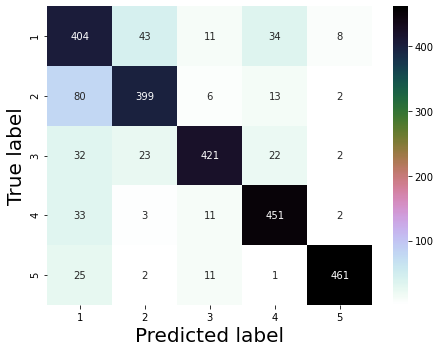

[80.8 79.8 84.2 90.2 92.2]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.70      0.81      0.75       500
Superventrical Ectopic       0.85      0.80      0.82       500
     Ventricular Beats       0.92      0.84      0.88       500
               Unknown       0.87      0.90      0.88       500
          Fusion Beats       0.97      0.92      0.95       500

              accuracy                           0.85      2500
             macro avg       0.86      0.85      0.86      2500
          weighted avg       0.86      0.85      0.86      2500

Micro avg
(0.8544, 0.8544, 0.8544, None)
Finished Training and testing


In [16]:
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, real_loader, real_test_ecg_balanced_loader, 50, criterion, optimizer, filename='real_data')

Epoch 1, train loss = 1.60334124216608, train acc = 0.2408
Epoch 2, train loss = 1.5817936097724765, train acc = 0.2876
Epoch 3, train loss = 1.5080355069019467, train acc = 0.438
Epoch 4, train loss = 1.2590663756307883, train acc = 0.6138
Epoch 5, train loss = 0.9137038473952889, train acc = 0.7084
Epoch 5, test loss = 1.1107273864575902, test acc = 0.6352
Epoch 6, train loss = 0.754836887817787, train acc = 0.7556
Epoch 7, train loss = 0.7011741278142402, train acc = 0.7656
Epoch 8, train loss = 0.6689997026463496, train acc = 0.7688
Epoch 9, train loss = 0.6414026453909971, train acc = 0.7746
Epoch 10, train loss = 0.6252118592693993, train acc = 0.7814
Epoch 10, test loss = 0.9051425304406298, test acc = 0.6808
Epoch 11, train loss = 0.5982501869717612, train acc = 0.7882
Epoch 12, train loss = 0.5793398164369319, train acc = 0.7938
Epoch 13, train loss = 0.5576707885069975, train acc = 0.8024
Epoch 14, train loss = 0.5349677379611772, train acc = 0.809
Epoch 15, train loss = 0.52

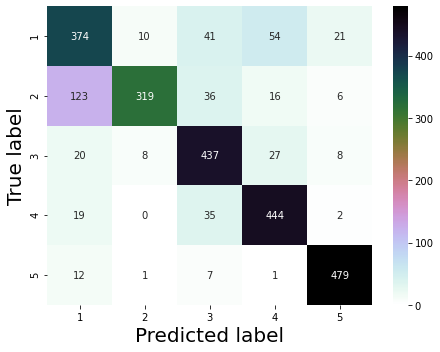

[74.8 63.8 87.4 88.8 95.8]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.68      0.75      0.71       500
Superventrical Ectopic       0.94      0.64      0.76       500
     Ventricular Beats       0.79      0.87      0.83       500
               Unknown       0.82      0.89      0.85       500
          Fusion Beats       0.93      0.96      0.94       500

              accuracy                           0.82      2500
             macro avg       0.83      0.82      0.82      2500
          weighted avg       0.83      0.82      0.82      2500

Micro avg
(0.8212, 0.8212, 0.8212, None)
Finished Training and testing


In [17]:
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, syn_loader, real_test_ecg_balanced_loader, 50, criterion, optimizer, filename='syn_data')

Epoch 1, train loss = 1.6066343406314085, train acc = 0.232
Epoch 2, train loss = 1.5911881417742773, train acc = 0.3216
Epoch 3, train loss = 1.5464176116570338, train acc = 0.4692
Epoch 4, train loss = 1.3811793455060735, train acc = 0.5118
Epoch 5, train loss = 1.0810463937000128, train acc = 0.6568
Epoch 5, test loss = 1.1682420769624384, test acc = 0.614
Epoch 6, train loss = 0.8596848860128354, train acc = 0.717
Epoch 7, train loss = 0.7749230664263266, train acc = 0.7452
Epoch 8, train loss = 0.7347213394081484, train acc = 0.7518
Epoch 9, train loss = 0.7029588853687301, train acc = 0.7604
Epoch 10, train loss = 0.6787689276080795, train acc = 0.7638
Epoch 10, test loss = 0.8855726860873414, test acc = 0.6932
Epoch 11, train loss = 0.648265017123411, train acc = 0.7714
Epoch 12, train loss = 0.6234058654496818, train acc = 0.7816
Epoch 13, train loss = 0.5965450543816595, train acc = 0.7872
Epoch 14, train loss = 0.5637930265298345, train acc = 0.804
Epoch 15, train loss = 0.53

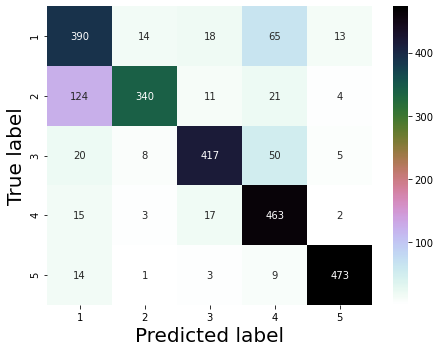

[78.  68.  83.4 92.6 94.6]
                        precision    recall  f1-score   support

     Non-Ectopic Beats       0.69      0.78      0.73       500
Superventrical Ectopic       0.93      0.68      0.79       500
     Ventricular Beats       0.89      0.83      0.86       500
               Unknown       0.76      0.93      0.84       500
          Fusion Beats       0.95      0.95      0.95       500

              accuracy                           0.83      2500
             macro avg       0.85      0.83      0.83      2500
          weighted avg       0.85      0.83      0.83      2500

Micro avg
(0.8332, 0.8332, 0.8332, None)
Finished Training and testing


In [18]:
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, mixed_loader, real_test_ecg_balanced_loader, 50, criterion, optimizer, filename='mixed_data')